In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import sbi.utils as utils

from sbi.inference import SNPE

In [2]:
N_POP = 4
N_SIMU = 200

In [3]:
H0 = torch.ones((N_POP)) * 100

In [4]:
low_r = torch.ones(N_POP) * 1e-2
high_r = torch.ones(N_POP) * 5e-1

low_diag = torch.ones(N_POP) * 1e-5
high_diag = torch.ones(N_POP) * 1e-4

low_diag_2 = torch.ones(N_POP-1) * 1e-5
high_diag_2 = torch.ones(N_POP-1) * 1e-4

low = torch.cat([low_r, low_diag, low_diag_2], axis=0)
high = torch.cat([high_r, high_diag, high_diag_2], axis=0)



In [5]:
prior = utils.BoxUniform(low=low, high=high)

In [6]:
def f(x, r, A):
    return r + A @ x


def simulator(theta):
    r = theta[:N_POP]
    A = (torch.diag(-theta[N_POP:2*N_POP]) + torch.diag(theta[2*N_POP:], diagonal=1)).reshape(N_POP, N_POP)
    
    H = torch.zeros((H0.shape[0], N_SIMU+1))
    H[:, 0] = H0.clone()
    dt = 0.1
    
    for i in range(1, N_SIMU+1):
        H[:, i] = H[:, i-1] + dt * H[:, i-1] * f(H[:, i-1], r, A)
    
    return H[None, :, :]

In [7]:
observations = simulator(prior.sample())

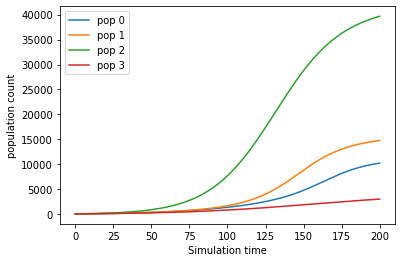

In [8]:
for i in range(N_POP):
    plt.plot(observations[0, i, :])

plt.legend([f"pop {i}" for i in range(N_POP)])
plt.xlabel("Simulation time")
plt.ylabel("population count")
plt.show()

In [9]:
embedding = nn.Sequential(
    nn.Conv1d(N_POP, 16, kernel_size=5),
    nn.ReLU(),
    nn.Conv1d(16, 16, kernel_size=5),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(3088, 20)
)

In [10]:
from sbi import utils
from sbi import inference
from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi

# make a SBI-wrapper on the simulator object for compatibility
simulator_wrapper, prior = prepare_for_sbi(simulator, prior)

# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(model='maf', 
                                      embedding_net=embedding)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(prior=prior, density_estimator=neural_posterior)

# run the inference procedure on one round and 10000 simulated data points
theta_samples, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=5000)

Running 5000 simulations.:   0%|          | 0/5000 [00:00<?, ?it/s]

In [11]:
density_estimator = inference.append_simulations(theta_samples, x).train()
posterior = inference.build_posterior(density_estimator)

Neural network successfully converged after 203 epochs.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

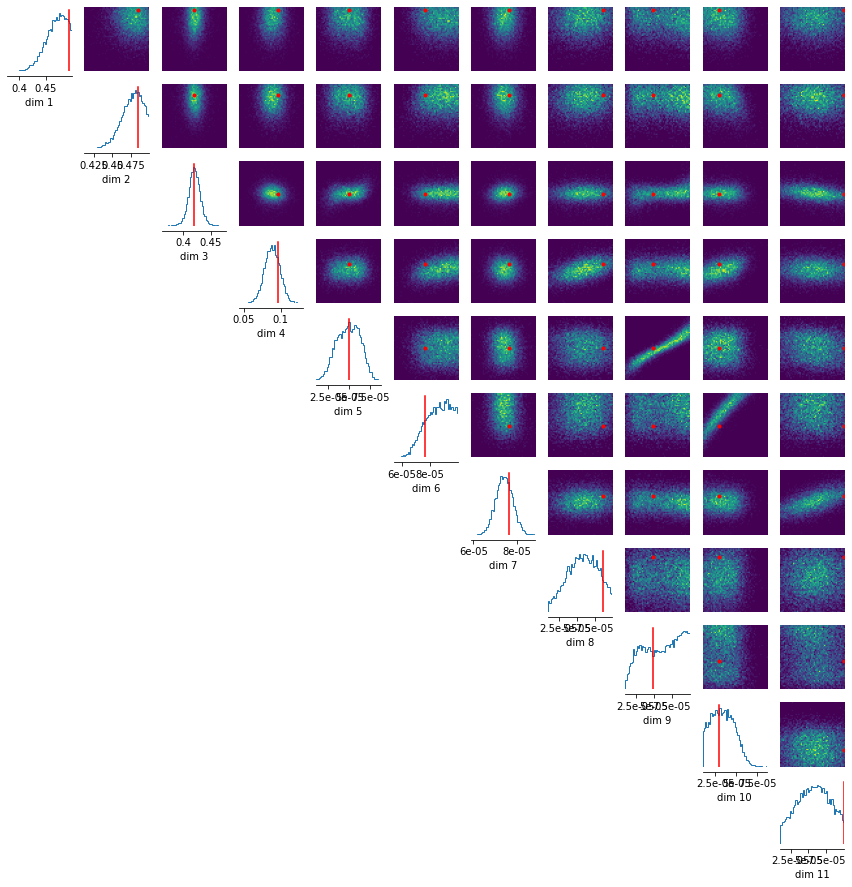

In [12]:
theta = prior.sample()

observation = simulator(theta)
samples = posterior.sample((10000,), x=observation)
log_probability = posterior.log_prob(samples, x=observation)
_ = utils.pairplot(samples,
                #    limits=[[0,0.5],[0,1e-4],[0,0.5], [0, 2e-4]],
                   points=theta,
                   points_offdiag={'markersize': 6},
                   points_colors='r',
                   fig_size=(15,15))

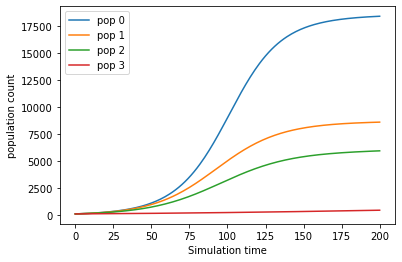

In [13]:
for i in range(N_POP):
    plt.plot(observation[0, i, :])

plt.legend([f"pop {i}" for i in range(N_POP)])
plt.xlabel("Simulation time")
plt.ylabel("population count")
plt.show()